In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns

# Problem Formulation 

Consider the system 
\begin{align}
s_{1,k+1} = s_{1,k} + \Delta t s_{2,k} + d_{1,k}
\end{align}

\begin{align}
s_{2,k+1} = -\frac{g.\Delta t}{l}\sin(s_{1,k}) + (1-\frac{b.\Delta t}{m.l^2})s_{2,k} + \frac{\Delta t}{m.l^2}u_k + d_{2,k}
\end{align}
where the true value of $b$ is $0.8$. However, we do not know it value. 


Let us formulate the problem as follows. our approximated model of the: 

\begin{align}
\hat{s}_{1,k+1} = s_{1,k} + 0.01 s_{2,k} 
\end{align}

\begin{align}
\hat{s}_{2,k+1} = 0.049\sin(s_{1,k}) + 0.99825s_{2,k} + 0.0025u_k
\end{align}

Where $d_k$ is the unknown disturbance resulted from $b$. The aim is to find $d_k$ from the obove model and the disturbed measurements of $s_{k+1}+\mathcal{N}(0, σ^2)$. Consider $\sigma=0.2$.

That is, we know $s_{k+1}, s_k, u_k$. We are trying to estimate 

\begin{align}
\hat d(s_k) = s_{k+1} - \hat{s}_{k+1}
\end{align}

In [4]:
 import numpy as np
 import matplotlib.pyplot as plt

In [5]:
def model(s1, s2, u, m):
    g = 9.8  # Acceleration due to gravity
    l = 1    # Length of Pendulum
    b = 0.8  # Damping Coefficient
    #m = 0.1    # Mass of Pendulum
    dt = 0.01
    return s1+dt*s2, -(g*dt/l)*np.sin(s1) + (1 - b*dt/(m*l*l))*s2 + (1/(m*l*l))*u

In [6]:
def generate_data(N=1000, sigma= 0.1, a = 0.1):
    s_01 = 0.5
    s_02 = 0
    S1_true = [s_01]
    S2_true = [s_02]
    S1_model = [s_01]
    S2_model = [s_02]
    D1 = []
    D2 = []
    
    for i in range(N):
        #K1 = k1 + 0.1*np.random.normal(0, 1)
        #K2 = k2 + 0.1*np.random.normal(0, 1)
        #K3 = k3 + 0.1*np.random.normal(0, 1)

        #u =  K3*np.random.uniform() + K2*np.random.normal(0, 1) #K1*(s0-1.)+ K2*np.cos(s0)+
        # print(u)
        dt = 0.01
        u = a*np.sin(i*dt)
        s1_t, s2_t = model(s_01, s_02, u, m = 0.1)
        s1_m, s2_m = model(s_01, s_02, u, m = 0.01)
        d1 = s1_t - s1_m + np.random.normal(0, sigma)
        d2 = s2_t - s2_m + np.random.normal(0, sigma)
        S1_true.append(s1_t)
        S1_model.append(s1_m)
        S2_true.append(s2_t)
        S2_model.append(s2_m)
        D1.append(d1)
        D2.append(d2)
        s_01 = s1_t
        s_02 = s2_t
    return S1_true, S1_model, D1, S2_true, S2_model, D2

In [7]:
T1, M1, D1, T2, M2, D2 = generate_data()
T1 = np.array(T1)
M1 = np.array(M1)
D1 = np.array(D1)
T2 = np.array(T2)
M2 = np.array(M2)
D2 = np.array(D2)

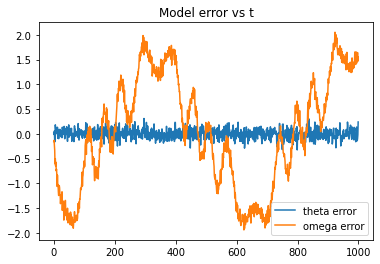

In [19]:
plt.plot(D1, label = "theta error")
plt.plot(D2, label = "omega error")
plt.title("Model error vs t")
plt.legend()

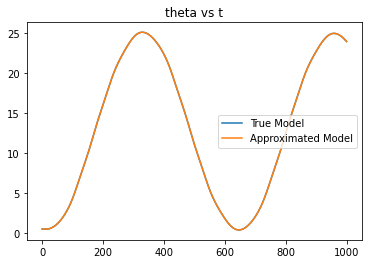

In [20]:
plt.plot(T1, label = "True Model")
plt.plot(M1, label = "Approximated Model")
plt.title("theta vs t")
plt.legend()

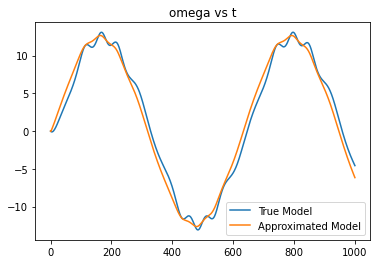

In [21]:
plt.plot(T2, label = "True Model")
plt.plot(M2, label = "Approximated Model")
plt.title("omega vs t")
plt.legend()

In [22]:
D1.shape, M1.shape, T1.shape, D2.shape, M2.shape, T2.shape

((1000,), (1001,), (1001,), (1000,), (1001,), (1001,))

In [23]:
X = np.hstack((M1[:-1].reshape((-1,1)),M2[:-1].reshape((-1,1)))) 
y1 = D1
y2 = D2

In [24]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, RationalQuadratic, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF

# X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
print(X.shape, y1.shape)
#kernel = ExpSineSquared(length_scale=1, periodicity=100) + DotProduct() + WhiteKernel() + RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + RBF(length_scale=.5, length_scale_bounds=(1e-2, 1e2)) + RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + RBF(length_scale=3.0, length_scale_bounds=(1e-2, 1e2)) + RationalQuadratic(length_scale=1.0, alpha=1.5)
kernel = ExpSineSquared(length_scale=10, periodicity=10) + DotProduct() + WhiteKernel() + RationalQuadratic(length_scale=1.0, alpha=2) 
gpr1 = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y1)
gpr1.score(X, y1)

mean, std = gpr1.predict(X[:2,:], return_std=True)


# X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
print(X.shape, y2.shape)
kernel = ExpSineSquared(length_scale=10, periodicity=10) + DotProduct() + WhiteKernel() + RationalQuadratic(length_scale=1.0, alpha=2)
gpr2 = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y2)
gpr2.score(X, y2)

mean, std = gpr2.predict(X[:2,:], return_std=True)

(1000, 2) (1000,)
(1000, 2) (1000,)


In [25]:
D1hat, D1std = gpr1.predict(X, return_std=True)
D2hat, D2std = gpr2.predict(X, return_std=True)

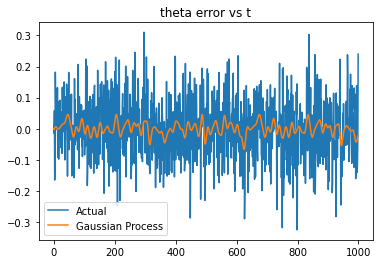

In [28]:
N_ploints = 1000

plt.plot(y1[:N_ploints], label = "Actual")
plt.plot(D1hat[:N_ploints], label = "Gaussian Process")
plt.title("theta error vs t")
plt.legend()

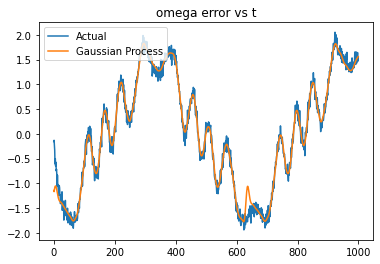

In [31]:
N_ploints = 1000

plt.plot(y2[:N_ploints], label = "Actual")
plt.plot(D2hat[:N_ploints], label = "Gaussian Process")
plt.title("omega error vs t")
plt.legend()

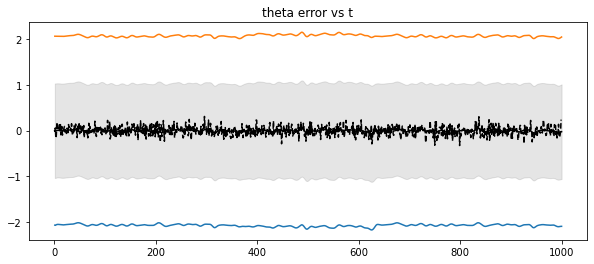

In [33]:
N_ploints = 1000
time = np.linspace(1, N_ploints, N_ploints)
fig, axs = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(10, 4))
plt.plot(time, D1hat[:N_ploints] - 2*D1std[:N_ploints])
plt.plot(time, D1hat[:N_ploints], color="black")
plt.plot(time, D1hat[:N_ploints] + 2*D1std[:N_ploints])
plt.plot(y1[:N_ploints], color='black', linestyle = '--' )
plt.title("theta error vs t")
plt.fill_between(time, D1hat[:N_ploints] - D1std[:N_ploints], D1hat[:N_ploints] + D1std[:N_ploints], alpha=0.1,color="black",label=r"$\pm$ 1 std. dev."    )

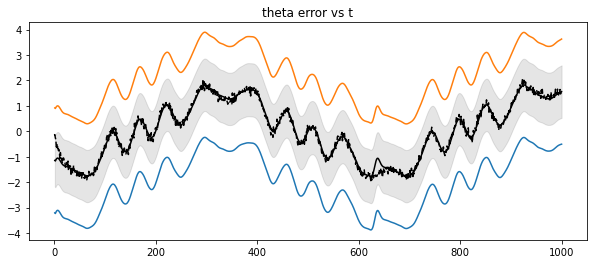

In [35]:
N_ploints = 1000
time = np.linspace(1, N_ploints, N_ploints)
fig, axs = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(10, 4))
plt.plot(time, D2hat[:N_ploints] - 2*D2std[:N_ploints])
plt.plot(time, D2hat[:N_ploints], color="black")
plt.plot(time, D2hat[:N_ploints] + 2*D2std[:N_ploints])
plt.plot(y2[:N_ploints], color='black', linestyle = '--' )
plt.title("theta error vs t")
plt.fill_between(time, D2hat[:N_ploints] - D2std[:N_ploints], D2hat[:N_ploints] + D2std[:N_ploints], alpha=0.1,color="black",label=r"$\pm$ 1 std. dev."    )

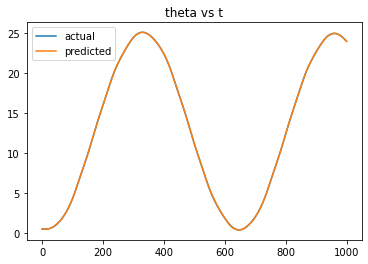

In [36]:
p = 1000
P1 = M1[:p] + D1hat[:p]
plt.plot(T1[:p], label = "actual")
plt.plot(P1[:p], label = "predicted")
plt.title('theta vs t')
plt.legend()

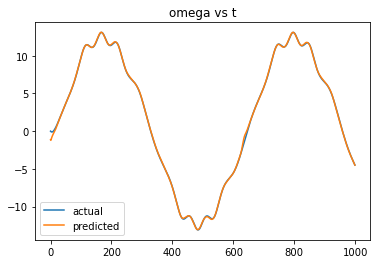

In [38]:
p = 1000
P2 = M2[:p] + D2hat[:p]
plt.plot(T2[:p], label = "actual")
plt.plot(P2[:p], label = "predicted")
plt.title('omega vs t')
plt.legend()

In [39]:
def generate_test_data(N=1000, sigma= 0.1, a = 0.2):
    s_01 = 0.5
    s_02 = 0
    S1_true = [s_01]
    S2_true = [s_02]
    S1_model = [s_01]
    S2_model = [s_02]
    D1 = []
    D2 = []
    
    for i in range(N):
        #K1 = k1 + 0.1*np.random.normal(0, 1)
        #K2 = k2 + 0.1*np.random.normal(0, 1)
        #K3 = k3 + 0.1*np.random.normal(0, 1)

        #u =  K3*np.random.uniform() + K2*np.random.normal(0, 1) #K1*(s0-1.)+ K2*np.cos(s0)+
        # print(u)
        dt = 0.01
        u = a*np.cos(1.5*i*dt) + a*np.sin(i*dt)
        s1_t, s2_t = model(s_01, s_02, u, m = 0.1)
        s1_m, s2_m = model(s_01, s_02, u, m = 0.01)
        d1 = s1_t - s1_m + np.random.normal(0, sigma)
        d2 = s2_t - s2_m + np.random.normal(0, sigma)
        S1_true.append(s1_t)
        S1_model.append(s1_m)
        S2_true.append(s2_t)
        S2_model.append(s2_m)
        D1.append(d1)
        D2.append(d2)
        s_01 = s1_t
        s_02 = s2_t
    return S1_true, S1_model, D1, S2_true, S2_model, D2

In [40]:
T1, M1, D1, T2, M2, D2 = generate_test_data()
T1 = np.array(T1)
M1 = np.array(M1)
D1 = np.array(D1)
T2 = np.array(T2)
M2 = np.array(M2)
D2 = np.array(D2)

In [41]:
X = np.hstack((M1[:-1].reshape((-1,1)),M2[:-1].reshape((-1,1))))
D1hat, D1std = gpr1.predict(X, return_std=True)
D2hat, D2std = gpr2.predict(X, return_std=True)

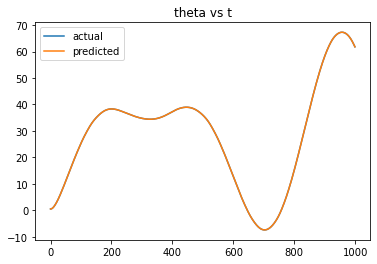

In [42]:
p = 1000
P1 = M1[:p] + D1hat[:p]
plt.plot(T1[:p], label = "actual")
plt.plot(P1[:p], label = "predicted")
plt.title('theta vs t')
plt.legend()

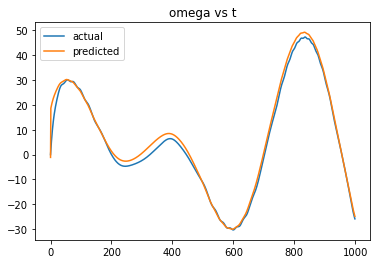

In [43]:
p = 1000
P2 = M2[:p] + D2hat[:p]
plt.plot(T2[:p], label = "actual")
plt.plot(P2[:p], label = "predicted")
plt.title('omega vs t')
plt.legend()